<a href="https://colab.research.google.com/github/Srinivaskolli45/s4_assignment/blob/main/s9_test1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import albumentations as Alb
import torchvision
import torchvision.transforms as transforms
import numpy as np


In [3]:
!pip install torchsummary
!pip install torch_lr_finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
#model 9

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary


class Ultimus_Block(nn.Module):
  def __init__(self):
    super(Ultimus_Block, self).__init__()
    self.k = nn.Linear(in_features=48, out_features=8)
    self.q = nn.Linear(in_features=48, out_features=8)
    self.v = nn.Linear(in_features=48, out_features=8)
    self.z_out = nn.Linear(in_features=8, out_features=48)

  def forward(self, x):
    
    x_k = self.k(x)
    x_q = self.q(x)
    x_v = self.v(x)
    AM = F.softmax(torch.matmul(x_k,torch.transpose(x_q, 0, 1)), dim=1) / np.sqrt(8)
    z = torch.matmul(AM, x_v)

    out = self.z_out(z)
    
    return x + out



class Transformer_VIT(nn.Module):
  def __init__(self):
    super(Transformer_VIT, self).__init__()

    self.ultimus_blk = Ultimus_Block()

    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels =3, out_channels=16, kernel_size=(3,3), padding=1, bias=False),      # Output - 16x32x32
        nn.BatchNorm2d(16),
        nn.ReLU())
    
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels =16, out_channels=32, kernel_size=(3,3), padding=1, bias=False),      # Output - 32x32x32
        nn.BatchNorm2d(32),
        nn.ReLU())
    
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels =32, out_channels=48, kernel_size=(3,3), padding=1, bias=False),      # Output - 48x32x32
        nn.BatchNorm2d(48),
        nn.ReLU())
    
    self.gap = nn.AvgPool2d(32)            # Output - 48x1x1

    self.ultimus_prime = nn.ModuleList([Ultimus_Block() for i in range(4)])

    self.fc = nn.Linear(in_features=48, out_features=10)

  def forward(self, x):

    x = self.conv1(x)
    x = self.conv2(x)
    x = self.gap(self.conv3(x))
    x = x.view(-1, 48)

    x = self.ultimus_blk(x)
    x = self.ultimus_blk(x)
    x = self.ultimus_blk(x)
    x = self.ultimus_blk(x)
    
    x = self.fc(x)
    return F.log_softmax(x, dim=-1)

In [5]:

import numpy as np
from torch.utils.data import Dataset
import albumentations as A
import torch

# custom dataset class for albumentations library
class AlbumentationImageDataset(Dataset):
  def __init__(self, image_list, train= True):
      self.image_list = image_list
      self.aug = A.Compose({
          A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
          A.Compose([A.PadIfNeeded(min_height=36, min_width=36, p=1), A.RandomCrop(32, 32)]),
          A.HorizontalFlip(),
          A.CoarseDropout(1, 8, 8, 1, 8, 8,fill_value=0.473363, mask_fill_value=None),
          A.ToGray()
      })

      self.norm = A.Compose({A.Normalize((0.49139968, 0.48215841, 0.44653091), (0.24703223, 0.24348513, 0.26158784)),
      })
      self.train = train
        
  def __len__(self):
      return (len(self.image_list))

  def __getitem__(self, i):
      
      image, label = self.image_list[i]
      
      if self.train:
        #apply augmentation only for training
        image = self.aug(image=np.array(image))['image']
      else:
        image = self.norm(image=np.array(image))['image']
      image = np.transpose(image, (2, 0, 1)).astype(np.float32)
      return torch.tensor(image, dtype=torch.float), label

In [6]:
import numpy as np
import torch
from tqdm import tqdm


def train(model, device, train_loader, criterion, scheduler, optimizer, use_l1=False, lambda_l1=0.01):
    """Function to train the model
    Args:
        model (instance): torch model instance of defined model
        device (str): "cpu" or "cuda" device to be used
        train_loader (instance): Torch Dataloader instance for trainingset
        criterion (instance): criterion to used for calculating the loss
        scheduler (function): scheduler to be used
        optimizer (function): optimizer to be used
        use_l1 (bool, optional): L1 Regularization method set True to use . Defaults to False.
        lambda_l1 (float, optional): Regularization parameter of L1. Defaults to 0.01.
    Returns:
        float: accuracy and loss values
    """
    model.train()
    pbar = tqdm(train_loader)
    lr_trend = []
    correct = 0
    processed = 0
    train_loss = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch 
        # accumulates the gradients on subsequent backward passes. Because of this, when you start your training loop, 
        # ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)
        # Calculate loss
        loss = criterion(y_pred, target)

        l1=0
        if use_l1:
            for p in model.parameters():
                l1 = l1 + p.abs().sum()
        loss = loss + lambda_l1*l1

        # Backpropagation
        loss.backward()
        optimizer.step()
        # updating LR
        if scheduler:
            if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step()
                lr_trend.append(scheduler.get_last_lr()[0])

        train_loss += loss.item()

        # Update pbar-tqdm
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        

        pbar.set_description(desc= f'Batch_id={batch_idx} Loss={train_loss/(batch_idx + 1):.5f} Accuracy={100*correct/processed:0.2f}%')
    return 100*correct/processed, train_loss/(batch_idx + 1), lr_trend

In [7]:
def test(model, device, test_loader, criterion):
    """put model in eval mode and test it
    Args:
        model (instance): torch model instance of defined model
        device (str): "cpu" or "cuda" device to be used
        test_loader (instance): Torch Dataloader instance for testset
        criterion (instance): criterion to used for calculating the loss
    Returns:
        float: accuracy and loss values
    """
    model.eval()
    test_loss = 0
    correct = 0
    #iteration = len(test_loader.dataset)// test_loader.batch_size
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset), test_loss



In [8]:
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import torch
import torchvision
import numpy as np
import copy
import torch.nn as nn
import albumentations as A
from torchvision import datasets
#from train import fit_model
#from data import AlbumentationImageDataset
#from Assignment_9_model import Transformer
from torch_lr_finder import LRFinder
from torchsummary import summary
import seaborn as sns



/usr/local/lib/python3.9/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [10]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available:", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    BATCH_SIZE=512
else:
    BATCH_SIZE=32
    

CUDA Available: True


In [11]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True )
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)


train_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(trainset, train=True), batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(AlbumentationImageDataset(testset, train=False), batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers=1)


100%|██████████| 170498071/170498071 [00:03<00:00, 45347017.40it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
net = Transformer_VIT().to(device)
print(summary(net, input_size=(3, 32, 32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,608
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 48, 32, 32]          13,824
       BatchNorm2d-8           [-1, 48, 32, 32]              96
              ReLU-9           [-1, 48, 32, 32]               0
        AvgPool2d-10             [-1, 48, 1, 1]               0
           Linear-11                    [-1, 8]             392
           Linear-12                    [-1, 8]             392
           Linear-13                    [-1, 8]             392
           Linear-14                   

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.83E-03


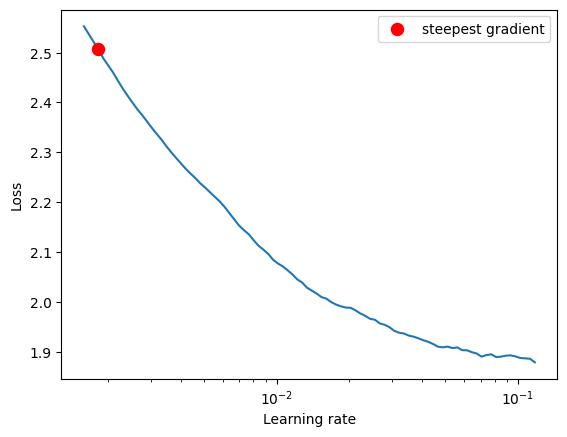

Max LR is 0.1175849554052157


In [13]:
exp_net = copy.deepcopy(net).to(device)
optimizer = torch.optim.Adam(exp_net.parameters(), lr=0.001)
criterion = nn.NLLLoss()

lr_finder = LRFinder(exp_net, optimizer, criterion, device=device)
lr_finder.range_test(train_loader, end_lr=10, num_iter=200)
lr_finder.plot()

min_loss = min(lr_finder.history['loss'])
ler_rate_1 = lr_finder.history['lr'][np.argmin(lr_finder.history['loss'], axis=0)]
print("Max LR is {}".format(ler_rate_1))


In [14]:

from torch.optim.lr_scheduler import OneCycleLR

ler_rate = ler_rate_1
print("Determined Max LR is:", ler_rate)


train_net_1 = copy.deepcopy(net).to(device)
optimizer = torch.optim.Adam(train_net_1.parameters(), lr=(ler_rate/10))


epochs = 24
steps_per_epoch = len(train_loader) 
total_steps = epochs * len(train_loader)
pct_start = (5*steps_per_epoch)/total_steps
print(f'pct_start --> {pct_start}')


Determined Max LR is: 0.1175849554052157
pct_start --> 0.20833333333333334


In [15]:
def save_model(model, epoch, optimizer, path):
    """Save torch model in .pt format
    Args:
        model (instace): torch instance of model to be saved
        epoch (int): epoch num
        optimizer (instance): torch optimizer
        path (str): model saving path
    """
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, path)


def fit_model(net, optimizer, criterion, device, NUM_EPOCHS,train_loader, test_loader, use_l1=False, scheduler=None, save_best=False):
    """Fit the model
    Args:
        net (instance): torch model instance of defined model
        optimizer (function): optimizer to be used
        criterion (instance): criterion to used for calculating the loss
        device (str): "cpu" or "cuda" device to be used
        NUM_EPOCHS (int): number of epochs for model to be trained
        train_loader (instance): Torch Dataloader instance for trainingset
        test_loader (instance): Torch Dataloader instance for testset
        use_l1 (bool, optional): L1 Regularization method set True to use. Defaults to False.
        scheduler (function, optional): scheduler to be used. Defaults to None.
        save_best (bool, optional): If save best model to model.pt file, paramater validation loss will be monitered
    Returns:
        (model, list): trained model and training logs
    """
    training_acc, training_loss, testing_acc, testing_loss = list(), list(), list(), list()
    lr_trend = []
    if save_best:
        min_val_loss = np.inf
        save_path = 'model.pt'

    for epoch in range(1,NUM_EPOCHS+1):
        print("EPOCH: {} (LR: {})".format(epoch, optimizer.param_groups[0]['lr']))
        
        train_acc, train_loss, lr_hist = train(
            model=net, 
            device=device, 
            train_loader=train_loader, 
            criterion=criterion ,
            optimizer=optimizer, 
            use_l1=use_l1, 
            scheduler=scheduler
        )
        test_acc, test_loss = test(net, device, test_loader, criterion)
        # update LR
        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(test_loss)
        
        if save_best:
            if test_loss < min_val_loss:
                print(f'Valid loss reduced from {min_val_loss:.5f} to {test_loss:.6f}. checkpoint created at...{save_path}\n')
                save_model(net, epoch, optimizer, save_path)
                min_val_loss = test_loss
            else:
                print(f'Valid loss did not inprove from {min_val_loss:.5f}\n')
        else:
            print()

        training_acc.append(train_acc)
        training_loss.append(train_loss)
        testing_acc.append(test_acc)
        testing_loss.append(test_loss)
        lr_trend.extend(lr_hist)    

    if scheduler:   
        return net, (training_acc, training_loss, testing_acc, testing_loss, lr_trend)
    else:
        return net, (training_acc, training_loss, testing_acc, testing_loss)

In [16]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=ler_rate,
                                                steps_per_epoch=steps_per_epoch, 
                                                epochs=epochs,
                                                pct_start=pct_start,
                                                div_factor=10,
                                                three_phase=False, 
                                                final_div_factor=50,
                                                anneal_strategy='linear'
                                                ) #final_div_factor=100,

In [17]:
train_net_1, history = fit_model(
    train_net_1, device=device,
    criterion = nn.CrossEntropyLoss(),
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer, 
    scheduler=scheduler, 
    NUM_EPOCHS=24
)




EPOCH: 1 (LR: 0.01175849554052157)


Batch_id=97 Loss=1.95371 Accuracy=26.28%: 100%|██████████| 98/98 [00:15<00:00,  6.24it/s]



Test set: Average loss: 1.6958, Accuracy: 3640/10000 (36.40%)

EPOCH: 2 (LR: 0.03296707031913103)


Batch_id=97 Loss=4.30588 Accuracy=30.13%: 100%|██████████| 98/98 [00:15<00:00,  6.20it/s]



Test set: Average loss: 320.3462, Accuracy: 1000/10000 (10.00%)

EPOCH: 3 (LR: 0.05417564509774048)


Batch_id=97 Loss=20.57189 Accuracy=11.00%: 100%|██████████| 98/98 [00:16<00:00,  5.78it/s]



Test set: Average loss: 2.3681, Accuracy: 1208/10000 (12.08%)

EPOCH: 4 (LR: 0.07538421987634994)


Batch_id=97 Loss=2.34748 Accuracy=14.12%: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 2.2450, Accuracy: 1738/10000 (17.38%)

EPOCH: 5 (LR: 0.09659279465495939)


Batch_id=97 Loss=2.26629 Accuracy=15.72%: 100%|██████████| 98/98 [00:16<00:00,  5.94it/s]



Test set: Average loss: 2.1430, Accuracy: 1910/10000 (19.10%)

EPOCH: 6 (LR: 0.11752193188991258)


Batch_id=97 Loss=2.21146 Accuracy=16.86%: 100%|██████████| 98/98 [00:15<00:00,  6.23it/s]



Test set: Average loss: 2.1186, Accuracy: 1988/10000 (19.88%)

EPOCH: 7 (LR: 0.11134562739020704)


Batch_id=97 Loss=2.17174 Accuracy=18.59%: 100%|██████████| 98/98 [00:15<00:00,  6.18it/s]



Test set: Average loss: 2.0625, Accuracy: 2013/10000 (20.13%)

EPOCH: 8 (LR: 0.1051693228905015)


Batch_id=97 Loss=2.14343 Accuracy=20.15%: 100%|██████████| 98/98 [00:15<00:00,  6.13it/s]



Test set: Average loss: 2.3001, Accuracy: 1712/10000 (17.12%)

EPOCH: 9 (LR: 0.09899301839079597)


Batch_id=33 Loss=2.25543 Accuracy=16.34%:  35%|███▍      | 34/98 [00:05<00:10,  6.19it/s]


KeyboardInterrupt: ignored

In [ ]:
training_acc, training_loss, testing_acc, testing_loss, lr_trend = history

sns.lineplot(x = list(range(1, 25)), y = training_acc)
sns.lineplot(x = list(range(1, 25)), y = testing_acc)
sns.lineplot(x = list(range(1, 25)), y = training_loss)
sns.lineplot(x = list(range(1, 25)), y = testing_loss)
sns.lineplot(x = list(range(1, len(lr_trend)+1)), y = lr_trend)